In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter
from scipy.optimize import root
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib import ticker

In [17]:
'''defaults for plotting + some util fxns'''
fontsize_legend = 20
fontsize_axes = 24
fontsize_ticks = 16
linewidth_all = 3
markersize_all = 8
size_extra = 4

figsize_whole = (6,5)
figsize_three = (15,5)
figsize_three_vert = (6, 13)
figsize_two = (10,5)
figsize_two_vert = (6, 10)
figsize_four_vert = (10, 17)
folder_out = 'figures_paper'
folder_exp = 'exp_results'
folder_out_extra = 'figures_ses'

# color_2folds = 'palevioletred'
color_2folds = 'goldenrod'
color_3folds = 'firebrick'
color_4folds = 'steelblue'
color_bend = 'forestgreen'
# color_4folds = 'deepskyblue'

colors_all = [color_2folds, color_3folds, color_4folds]

def smooth_pv_data(pressure, window_len = 100):
    # window_len = 100
    poly_order = 2
    len_pressure, num_exp = np.shape(pressure)

    pressure_smooth = np.zeros((len_pressure, num_exp))

    for i in range(num_exp):
        pressure_smooth[:,i] = savgol_filter(pressure[:,i], window_len, poly_order)
    
    return pressure_smooth

def rescale_eigenvalue(eigenvalues_cur):
    return np.sign(eigenvalues_cur) * np.sqrt(np.abs(eigenvalues_cur)) * 1/(2*np.pi)

def highlight_mode(freq_all, initial_i, initial_j, num_samp, num_pts = 2, select_fac = 1):
    j_all = np.zeros(np.shape(freq_all)[0], dtype = int)
    i_all = np.arange(np.shape(freq_all)[0], dtype = int)
    j_all[initial_i] = initial_j
    cut_idx = initial_i[0] + np.arange(num_samp + 2)

    for idx in range(0, num_samp, select_fac):
        i_next = idx + initial_i[1] + select_fac #min value 2

        if idx <= select_fac * (num_pts - 2): num_pts_temp = 2
        else: num_pts_temp = num_pts

        if idx == 0: i_cur = [i_next - select_fac - 1, i_next - select_fac]
        else: i_cur = [i_next - select_fac * (num_pts_temp - i) for i in range(num_pts_temp)]
        j_cur = [j_all[i] for i in i_cur]
        
        vals_cur = np.array([freq_all[i,j] for i,j in zip(i_cur, j_cur)])

        if idx == 0: val_new_est = vals_cur[-1] + select_fac * np.mean(np.diff(vals_cur))
        else: val_new_est = vals_cur[-1] + np.mean(np.diff(vals_cur))

        j_all[i_next] = np.argmin(np.abs(freq_all[i_next,:] - val_new_est))

        if select_fac > 1:
            j_all[i_cur[-1] + 1:i_next] = int(np.mean([j_all[i_cur[-1]], j_all[i_next]]))
    return (i_all, j_all, cut_idx)


In [62]:
'''fxns to plot exp/sim pv/dv/freq'''
def plot_exp_pv(axis, num_folds):
    color = colors_all[num_folds - 2]

    data_all = np.load(f'{folder_exp}/PV_{num_folds}folds_processed.npz')
    axis.plot(data_all['vol_norm'], data_all['pressure'], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
    axis.fill_between(data_all['vol_norm'], data_all['pressure'] + data_all['pressure_std'], data_all['pressure'] - data_all['pressure_std'], alpha = 0.3, color = color)

def plot_sim_pv(axis, num_folds, idx_end = 0, static = False, color = None):
    if color is None: color = colors_all[num_folds - 2]
    if static:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    else:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data.npz')
    idx_end = idx_end + len(data['vol_norm'])
    
    axis.plot(data['vol_norm'][:idx_end], data['pressure'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)

def plot_exp_dv(axes, num_folds, select_fac = 1, offset_plots = 0):
    color = colors_all[num_folds - 2]
    data_all = np.load(f'{folder_exp}/DV_{num_folds}folds_processed.npz')

    axes[0 + offset_plots].plot(data_all['vol_norm'][::select_fac], 100 * data_all['contraction'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
    axes[0 + offset_plots].fill_between(data_all['vol_norm'][::select_fac], 100 * (data_all['contraction'][::select_fac] + data_all['contraction_std'][::select_fac]), 100 * (data_all['contraction'][::select_fac] - data_all['contraction_std'][::select_fac]), alpha = 0.3, color = color)

    axes[1 + offset_plots].plot(data_all['vol_norm'][::select_fac], data_all['twist'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
    axes[1 + offset_plots].fill_between(data_all['vol_norm'][::select_fac], data_all['twist'][::select_fac] + data_all['twist_std'][::select_fac], data_all['twist'][::select_fac] - data_all['twist_std'][::select_fac], alpha = 0.3, color = color)

def plot_sim_dv(axes, num_folds, flip = 1, idx_end = 0, static = False, color = None, offset_plots = 0):
    if color is None: color = colors_all[num_folds - 2]
    
    if static:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    else:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data.npz')
    idx_end = idx_end + len(data['vol_norm'])
    axes[0 + offset_plots].plot(data['vol_norm'][:idx_end], 100 * data['contraction_strain'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)
    axes[1 + offset_plots].plot(data['vol_norm'][:idx_end], flip * data['twist_deg'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)

def plot_exp_bend(axes, offset_plots = 0, plot_prop = 'both', select_fac = 1):
    data_pv = np.load(f'{folder_exp}/PV_bender_processed.npz')
    data_ba = np.load(f'{folder_exp}/DV_bender_processed.npz')

    if plot_prop == 'pv' or plot_prop == 'both':
        axes[0 + offset_plots].plot(data_pv['vol_norm'][::select_fac], data_pv['pressure'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color_bend)
        axes[0 + offset_plots].fill_between(data_pv['vol_norm'][::select_fac], data_pv['pressure'][::select_fac] + data_pv['pressure_std'][::select_fac],
                                data_pv['pressure'][::select_fac] - data_pv['pressure_std'][::select_fac], alpha = 0.3, color = color_bend)
    if plot_prop == 'ba' or plot_prop == 'both':
        axes[1 + offset_plots].plot(data_ba['vol_norm'][::select_fac], data_ba['bending_angle'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color_bend)
        axes[1 + offset_plots].fill_between(data_ba['vol_norm'][::select_fac], data_ba['bending_angle'][::select_fac] - data_ba['ba_std'][::select_fac],
                                data_ba['bending_angle'][::select_fac] + data_ba['ba_std'][::select_fac], alpha = 0.3, color = color_bend)

def plot_sim_bend(axes, offset_plots = 0, plot_prop = 'both', idx_end = 0):
    data = np.load(f'{folder_out}/sim_bender_data.npz')

    idx_end = idx_end + len(data['vol_norm'])

    if plot_prop == 'pv' or plot_prop == 'both':
        axes[0 + offset_plots].plot(data['vol_norm'][:idx_end], data['pressure'][:idx_end], label = 'FEM', color = color_bend, linewidth = linewidth_all)
    
    if plot_prop == 'ba' or plot_prop == 'both':
        axes[1 + offset_plots].plot(data['vol_norm'][:idx_end], data['ba_deg'][:idx_end], label = 'FEM', color = color_bend, linewidth = linewidth_all)



def plot_freq(axis, num_folds, rescale = True, alpha = 0.1):
    color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    for j in range(np.shape(data['eigval'])[1]):
        if rescale: freq_plot = data['eigval_rescale'][:,j]
        else: freq_plot = data['eigval'][:,j]
        # axis.plot(data['vol_norm'], freq_plot, '--', color = color, linewidth = linewidth_all, alpha = alpha)
        axis.plot(data['vol_norm_freq'], freq_plot, '.', color = color, markersize = markersize_all, alpha = alpha)

def plot_highlighted_mode(axis, num_folds, rescale = True, i_initial = None, j_initial = None, idx_end = -1, num_pts = 2, select_fac = 1, color = None):
    extra_thickness = 3
    if color is None: color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    num_samp = int((np.shape(data['eigval'])[0] - i_initial[-1] + idx_end))
    i_all, j_all, cut_idx = highlight_mode(data['eigval'], i_initial, j_initial, num_samp, num_pts = num_pts, select_fac = select_fac)
    if rescale: mode_plot = rescale_eigenvalue(data['eigval'][i_all[cut_idx],j_all[cut_idx]])
    else: mode_plot = data['eigval'][i_all[cut_idx],j_all[cut_idx]]
    # axis.plot(data['vol_norm'][i_all[cut_idx]], mode_plot, 'o', color = color, linewidth = linewidth_all + extra_thickness)
    axis.plot(data['vol_norm_freq'][i_all[cut_idx]], mode_plot, color = color, linewidth = linewidth_all + extra_thickness)
    return i_all[cut_idx[-1]]

def make_highlighted_mode(num_folds, i_initial = None, j_initial = None, idx_end = -1, num_pts = 2, select_fac = 1, color = None):
    if color is None: color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    num_samp = int((np.shape(data['eigval'])[0] - i_initial[-1] + idx_end))
    i_all, j_all, cut_idx = highlight_mode(data['eigval'], i_initial, j_initial, num_samp, num_pts = num_pts, select_fac = select_fac)
    return (i_all[cut_idx[-1]], data['vol_norm_freq'][i_all[cut_idx]], data['eigval'][i_all[cut_idx],j_all[cut_idx]])

def plot_single_mode(axis, num_folds, vol_data, eig_data, rescale = True, color = None, extra_thickness = 3):
    if color is None: color = colors_all[num_folds - 2]
    if rescale: mode_plot = rescale_eigenvalue(eig_data)
    else: mode_plot = eig_data

    axis.plot(vol_data, mode_plot, color = color, linewidth = linewidth_all + extra_thickness)
    return np.nanargmin(eig_data)
    
    
def plot_highlighted_mode_piecewise(axis, num_folds, i_initial_0, j_initial_all, num_pts_all, select_fac_all, idx_end_all, vert_line = False, rescale = True, extra_thickness = 3, color_vert_line = None, pts_plot = None):
    color = colors_all[num_folds - 2]
    vol_all = []
    eig_all = []
    i_initial = i_initial_0

    for i in range(len(j_initial_all)):
        idx_paste, vol_data, eig_data = make_highlighted_mode(num_folds, i_initial = i_initial, j_initial = j_initial_all[i], num_pts = num_pts_all[i], select_fac = select_fac_all[i], idx_end = idx_end_all[i])
        i_initial = [idx_paste, idx_paste + 1]
        if i == 0:
            vol_all.extend(vol_data)
            eig_all.extend(eig_data)
        else:
            vol_all.extend(vol_data[1:])
            eig_all.extend(eig_data[1:])
    min_loc = plot_single_mode(axis, num_folds, vol_all, eig_all, rescale = rescale, extra_thickness = extra_thickness)
    if pts_plot is not None:
        plot_pts_freq(axis, num_folds, frames = pts_plot, volume = vol_all, highlighted_mode = eig_all)
    if vert_line:
        plot_vert_line_freq(axis, num_folds, min_loc, alpha = 0.3, color = color_vert_line)
    np.savetxt(f'{folder_out}/{num_folds}folds_twist_eig.txt', np.array([vol_all,eig_all]).T, header = '\Delta V/V_0 | eigenvalue')
    return vol_all[min_loc]

def plot_vert_line_freq(axis, num_folds, idx_vert, alpha = 1, color = None):
    if color is None: color = 'k'
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    ylim_cur = axis.get_ylim()
    if ylim_cur[0] < 0: fac_mult = 2
    else: fac_mult = 0.5

    print(f"{num_folds}folds twist onset: \Delta V/V_0 = {data['vol_norm_freq'][idx_vert]:.3f}")
    axis.vlines(data['vol_norm_freq'][idx_vert], ylim_cur[0]*fac_mult, ylim_cur[1]*2, color = color, linestyles = 'dashed', linewidth = linewidth_all, alpha = alpha)

def plot_pts_freq(axis, num_folds, frames, volume, highlighted_mode):
    color = colors_all[num_folds - 2]

    frames = np.array(frames, dtype = int)
    volume = np.array(volume)
    highlighted_mode = np.array(highlighted_mode)
    axis.plot(volume[frames], highlighted_mode[frames], '.', color = color, markersize = markersize_all + 4)

def plot_vert_line(axis, x_val, alpha = 1, color = None):
    if color is None: color = 'k'
    ylim_cur = axis.get_ylim()
    if ylim_cur[0] < 0: fac_mult = 2
    else: fac_mult = 0.5

    axis.vlines(x_val, ylim_cur[0]*fac_mult, ylim_cur[1]*2, color = color, linestyles = 'dashed', linewidth = linewidth_all, alpha = alpha)

def plot_lin_mode(axis, num_folds, color = None, extra_thickness = 5, add_border = False):
    if num_folds == 'bend': color = color_bend
    elif color is None: color = colors_all[num_folds - 2]
    data_all = np.load(f'{folder_out}/sim_{num_folds}folds_lin_data.npz')

    x_append = [data_all['x_plot'][0], (data_all['x_plot'][0] + data_all['x_plot'][1])/2]
    y_append = [data_all['y_plot'][0], (data_all['y_plot'][0] + data_all['y_plot'][1])/2]

    x_plot = np.append(data_all['x_plot'], x_append)
    y_plot = np.append(data_all['y_plot'], y_append)

    if add_border:
        axis.plot(x_plot, y_plot, linewidth = linewidth_all + extra_thickness + 1, color = 'white', solid_capstyle='round')
    axis.plot(x_plot, y_plot, linewidth = linewidth_all + extra_thickness, color = color, solid_capstyle='round')
    

    axis.set_aspect('equal', 'box')
    axis.axis('off')
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])


In [4]:
'''improve plot fxns'''
def improve_plot_multi(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None, sharex = False, sharey = False):
    if isinstance(axis, np.ndarray):
        #is a list, do list things
        if not isinstance(xlabel, list): xlabel = [xlabel] * len(axis)
        if not isinstance(ylabel, list): ylabel = [ylabel] * len(axis)
        if not isinstance(ylim_top, list): ylim_top = [ylim_top] * len(axis)
        if not isinstance(ylim_bottom, list): ylim_bottom = [ylim_bottom] * len(axis)
        if not isinstance(xlim_left, list): xlim_left = [xlim_left] * len(axis)
        if not isinstance(xlim_right, list): xlim_right = [xlim_right] * len(axis)

        for i in range(len(axis)):
            axis[i].tick_params(labelsize = fontsize_ticks)
        
        if axis[0].get_gridspec().ncols > 1:
            #single row, assuming set ylabel on [0] only unless sharey is False
            for i in range(len(axis)):
                if i == 0 or not sharey:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], xlabel = xlabel[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                    
        else:
            #single col
            for i in range(len(axis)):
                if i == len(axis)-1 or not sharex:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i])
    else:
        #is just ax by itself
        improve_plot(axis, xlabel = xlabel, ylabel = ylabel, ylim_top = ylim_top, ylim_bottom = ylim_bottom, xlim_left = xlim_left, xlim_right = xlim_right)

def improve_plot(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None):
    #is just ax by itself
    axis.set_ylim(top = ylim_top, bottom = ylim_bottom)
    axis.set_xlim(left = xlim_left, right = xlim_right)
    axis.set_ylabel(ylabel, fontsize = fontsize_axes)
    axis.set_xlabel(xlabel, fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)

In [578]:
np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS[color_2folds]))*255
mcolors.CSS4_COLORS[color_2folds]

'#DAA520'

In [19]:
'''fxns for find n/p_cr'''
def find_n(R,t,H):
    v1 = R/float(H)
    v2 = t/float(R)
    print(f'({(v2*v1):.3f}, {v1:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    return np.argmin(p_cr_all) + 2


def find_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    print(v2)
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)
    

    p_cr_all = [p_cr(n) for n in n_all]
    return n_all[np.argmin(p_cr_all)]

def find_pcr_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    idx_min = np.argmin(p_cr_all)
    return (n_all[idx_min], p_cr_all[idx_min])



In [20]:
num_try_R = 400
num_try_t = 400

n_all = np.zeros((num_try_R, num_try_t), dtype = int)
p_cr_all = np.zeros((num_try_R, num_try_t))

v_R_try = np.linspace(0.1,0.6, num_try_R)
v_t_try = np.linspace(0.01,0.05, num_try_t)

for i,v_R in enumerate(v_R_try):
    for j,v_t in enumerate(v_t_try):
        n_cur, p_cr_cur = find_pcr_n_alt(v_R, v_t)
        n_all[i,j] = int(n_cur)
        p_cr_all[i,j] = p_cr_cur

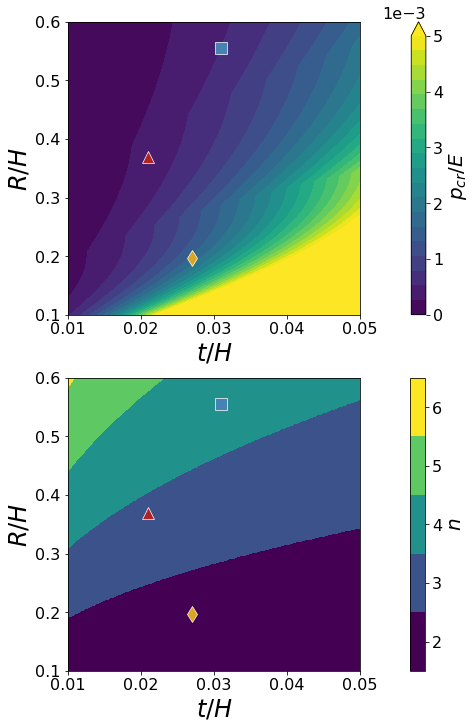

In [21]:
'''contour plot for n folds and p_cr'''
fig, ax = plt.subplots(2,1, figsize = (6.5,10), constrained_layout = True)

edge_width_all = 0.7
cmap_use = 'viridis'
# ax.imshow(res_all)
ax[0].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.linspace(0,0.005,20)
map_thing = ax[0].contourf(yv, xv, p_cr_all, levels = levels_set, cmap = cmap_use, extend = 'max')



cbar = fig.colorbar(map_thing, extend = 'max', ticks=[0, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3], pad = 0.015)
cbar.set_label(label = '$p_{cr}/E$', size = fontsize_legend)
cbar.ax.ticklabel_format(scilimits = (-2,3))
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.ax.yaxis.offsetText.set_fontsize(fontsize_ticks)

############################

ax[1].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5
map_thing = ax[1].contourf(yv, xv, n_all, levels = levels_set, cmap = cmap_use, vmin = 2, vmax = 6)



cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6], pad = 0.11)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label(label = '$n$', size = fontsize_legend)

for axis in ax:
    axis.set_xlabel('$t/H$', fontsize = fontsize_axes)
    axis.set_ylabel('$R/H$', fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlim(np.min(v_t_try), np.max(v_t_try))
    axis.set_ylim(np.min(v_R_try), np.max(v_R_try))


fig.savefig(f'{folder_out}/fig1_model_linspace.png', dpi = 300)
fig.savefig(f'{folder_out}/fig1_model_linspace.pdf')


In [8]:
E = 1.1

n, p_cr = find_pcr_n_alt(v_t = 0.027, v_R = 0.197)
print(f'{n} folds: p_cr/E = {p_cr:.3e}, p_cr = {p_cr*1e3*E:.3} kPa')

n, p_cr = find_pcr_n_alt(v_t = 0.021, v_R = 0.370)
print(f'{n} folds: p_cr/E = {p_cr:.3e}, p_cr = {p_cr*1e3*E:.3} kPa')

n, p_cr = find_pcr_n_alt(v_R = 0.556, v_t = 0.031)
print(f'{n} folds: p_cr/E = {p_cr:.3e}, p_cr = {p_cr*1e3*E:.3} kPa')

2 folds: p_cr/E = 1.636e-03, p_cr = 1.8 kPa
3 folds: p_cr/E = 3.493e-04, p_cr = 0.384 kPa
4 folds: p_cr/E = 5.262e-04, p_cr = 0.579 kPa


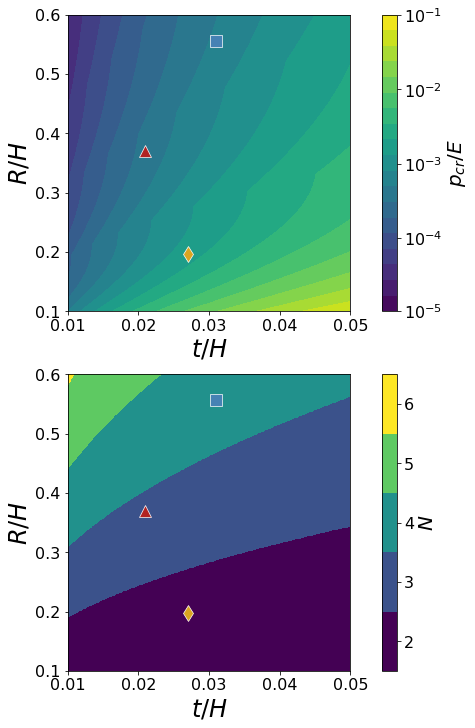

In [604]:
fig, ax = plt.subplots(2,1, figsize = (6.5,10), constrained_layout = True)

edge_width_all = 0.7
# ax.imshow(res_all)
ax[0].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')

map_thing = ax[0].contourf(yv, xv, p_cr_all, cmap = 'viridis', levels=np.logspace(-5,-1, 20), norm = LogNorm())



ticks_set = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
ticks_set_power = [int(np.log10(t)) for t in ticks_set]
cbar = fig.colorbar(map_thing, ticks = ticks_set)
cbar.ax.yaxis.set_ticks(ticks_set, labels=[f"$10^{{{val}}}$" for val in ticks_set_power])
cbar.set_label(label = '$p_{cr}/E$', size = fontsize_legend)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.ax.yaxis.offsetText.set_fontsize(fontsize_ticks)

############################

ax[1].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5
map_thing = ax[1].contourf(yv, xv, n_all, levels = levels_set, cmap = 'viridis', vmin = 2, vmax = 6)



cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6])
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label(label = '$N$', size = fontsize_legend)

for axis in ax:
    axis.set_xlabel('$t/H$', fontsize = fontsize_axes)
    axis.set_ylabel('$R/H$', fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlim(np.min(v_t_try), np.max(v_t_try))
    axis.set_ylim(np.min(v_R_try), np.max(v_R_try))

fig.savefig(f'{folder_out}/fig1_model_logspace.png', dpi = 300)

In [10]:
'''process 2/3/4 exp pv and save data'''
exp_folder = 'exp_results'

'''load exp 4 folds'''
num_folds = 4
data_all = np.loadtxt('exp_results/PV_4folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(6)))
vol_all = data_all[:,0]

pressure_4_smooth = smooth_pv_data(data_all[:,1:], 300)
pressure_4_smooth_mean = np.mean(pressure_4_smooth, axis = 1)
pressure_4_smooth_std = np.std(pressure_4_smooth, axis = 1)

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

vol_norm = vol_all / vol_0
np.savez(f'{exp_folder}/PV_{num_folds}folds_processed', vol_norm = vol_norm, pressure = pressure_4_smooth_mean, pressure_std = pressure_4_smooth_std)

'''load 3 folds exp data'''
num_folds = 3
data_all = np.loadtxt('exp_results/PV_3folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols=(0,1,3,4,5))
vol_all = data_all[:,0]

pressure_3_smooth = smooth_pv_data(data_all[:,1:], 400)
pressure_3_smooth_mean = np.mean(pressure_3_smooth, axis = 1)
pressure_3_smooth_std = np.std(pressure_3_smooth, axis = 1)

R = 10 #mm
H = 27 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
vol_norm = vol_all / vol_0
np.savez(f'{exp_folder}/PV_{num_folds}folds_processed', vol_norm = vol_norm, pressure = pressure_3_smooth_mean, pressure_std = pressure_3_smooth_std)

'''2 folds exp data'''
num_folds = 2
data_all = np.loadtxt('exp_results/PV_2folds_R9_1p2.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(7)))
vol_all = data_all[:,0]
pressure_2 = data_all[:,1:]
pressure_2_smooth = smooth_pv_data(pressure_2)
pressure_2_smooth_mean = np.mean(pressure_2_smooth, axis = 1)
pressure_2_smooth_std = np.std(pressure_2_smooth, axis = 1)

R = 8.8 #mm
H = 44.75 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
vol_norm = vol_all / vol_0
np.savez(f'{exp_folder}/PV_{num_folds}folds_processed', vol_norm = vol_norm, pressure = pressure_2_smooth_mean, pressure_std = pressure_2_smooth_std)


In [5]:
'''process 2/3/4 sim pv + everything and save data'''
data_dir = 'data_out'

'''load 4 folds sim data'''
# idx_load = 202
idx_load = 219
num_folds = 4

cvol, pcav = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_contraction_twist.txt', unpack = True)

vol_norm = -(cvol - cvol[0]) / cvol[0]
pressure_kpa = pcav * 1e3
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_data', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)

'''load 3 folds sim data'''
# idx_load = 204
idx_load = 220
num_folds = 3

cvol, pcav = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_contraction_twist.txt', unpack = True)

vol_norm = -(cvol - cvol[0]) / cvol[0]
pressure_kpa = pcav * 1e3
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_data', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)

'''load 2 folds sim data'''
idx_load = 203
# idx_load = 221
num_folds = 2

cvol, pcav = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_contraction_twist.txt', unpack = True)

vol_norm = -(cvol - cvol[0]) / cvol[0]
pressure_kpa = pcav * 1e3
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_data', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)


In [6]:
'''process 2/3/4 sim static pv + everything and save data'''
data_dir = 'data_out'

'''load 4 folds sim data'''
idx_load = 216
num_folds = 4

cvol, pcav = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_contraction_twist.txt', unpack = True)

vol_norm = -(cvol - cvol[0]) / cvol[0]
pressure_kpa = pcav * 1e3
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_data_static', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)
np.savez(f'{folder_out_extra}/sim_{num_folds}folds_data_static', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)

'''load 3 folds sim data'''
idx_load = 217
num_folds = 3

cvol, pcav = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_contraction_twist.txt', unpack = True)

vol_norm = -(cvol - cvol[0]) / cvol[0]
pressure_kpa = pcav * 1e3
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_data_static', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)
np.savez(f'{folder_out_extra}/sim_{num_folds}folds_data_static', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)

'''load 2 folds sim data'''
idx_load = 215
num_folds = 2

cvol, pcav = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_contraction_twist.txt', unpack = True)

vol_norm = -(cvol - cvol[0]) / cvol[0]
pressure_kpa = pcav * 1e3
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_data_static', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)
np.savez(f'{folder_out_extra}/sim_{num_folds}folds_data_static', vol_norm = vol_norm, pressure = pressure_kpa, contraction_strain = contraction_strain, twist_deg = twist_deg)


In [552]:
'''process 2/3/4 exp cont/twist and save data'''
exp_folder = 'exp_results'

'''4 folds exp'''
num_folds = 4
exp_data = np.loadtxt('exp_results/DV_4f_Exp_Updated.csv', skiprows = 1, delimiter=',')
vol_norm = exp_data[:,0]
twist_all = exp_data[:,1:4]
contraction_all = exp_data[:,4:7]

twist_mean = np.mean(twist_all, axis = 1)
twist_std = np.std(twist_all, axis = 1)

contraction_mean = np.mean(contraction_all, axis = 1)
contraction_std = np.std(contraction_all, axis = 1)
np.savez(f'{exp_folder}/DV_{num_folds}folds_processed', vol_norm = vol_norm, twist = twist_mean, twist_std = twist_std, contraction = contraction_mean, contraction_std = contraction_std)

'''3 folds exp'''
num_folds = 3
exp_data = np.loadtxt('exp_results/DV_3f_Exp.csv', skiprows = 1, delimiter=',')
vol_norm = exp_data[:,0]
twist_all = exp_data[:,1:4]
contraction_all = exp_data[:,4:7]

twist_mean = np.mean(twist_all, axis = 1)
twist_std = np.std(twist_all, axis = 1)

contraction_mean = np.mean(contraction_all, axis = 1)
contraction_std = np.std(contraction_all, axis = 1)
np.savez(f'{exp_folder}/DV_{num_folds}folds_processed', vol_norm = vol_norm, twist = twist_mean, twist_std = twist_std, contraction = contraction_mean, contraction_std = contraction_std)

'''2 folds exp'''
num_folds = 2
exp_data = np.loadtxt('exp_results/DV_2f_Exp.csv', skiprows = 1, delimiter=',')
vol_norm = exp_data[:,0]
twist_all = np.zeros((len(vol_norm), 3))
contraction_all = exp_data[:,1:4]/100

twist_mean = np.mean(twist_all, axis = 1)
twist_std = np.std(twist_all, axis = 1)

contraction_mean = np.mean(contraction_all, axis = 1)
contraction_std = np.std(contraction_all, axis = 1)
np.savez(f'{exp_folder}/DV_{num_folds}folds_processed', vol_norm = vol_norm, twist = twist_mean, twist_std = twist_std, contraction = contraction_mean, contraction_std = contraction_std)


In [462]:
'''process 2/3/4 sim freq and save data'''

data_dir = 'data_out'

'''load 4 folds sim data'''
num_folds = 4
idx_cur = 402

data_cur = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_eig_val.txt')
vol_norm = -3*data_cur[:,0]
freq_all = data_cur[:,1:]
freq_rescale = np.array([rescale_eigenvalue(freq_all[:,j]) for j in range(np.shape(freq_all)[1])]).T
cvol, pcav = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_contraction_twist.txt', unpack = True)
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_freq', vol_norm_freq = vol_norm, eigval = freq_all, eigval_rescale = freq_rescale, pressure = pcav*1e3, vol_norm = 1 - cvol/cvol[0], contraction_strain = contraction_strain, twist_deg = twist_deg)

'''load 3 folds sim data'''
num_folds = 3
idx_cur = 262

data_cur = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_eig_val.txt')
vol_norm = -3*data_cur[:,0]
freq_all = data_cur[:,1:]
freq_rescale = np.array([rescale_eigenvalue(freq_all[:,j]) for j in range(np.shape(freq_all)[1])]).T
cvol, pcav = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_contraction_twist.txt', unpack = True)
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_freq', vol_norm_freq = vol_norm, eigval = freq_all, eigval_rescale = freq_rescale, pressure = pcav*1e3, vol_norm = 1 - cvol/cvol[0], contraction_strain = contraction_strain, twist_deg = twist_deg)

'''load 2 folds sim data'''
num_folds = 2
idx_cur = 143

data_cur = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_eig_val.txt')
vol_norm = -3*data_cur[:,0]
freq_all = data_cur[:,1:]
freq_rescale = np.array([rescale_eigenvalue(freq_all[:,j]) for j in range(np.shape(freq_all)[1])]).T
cvol, pcav = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_pcav_cvol.txt', unpack = True)
t_all, contraction_all, twist_all = np.loadtxt(f'{data_dir}/{num_folds}fold-test_static-stable-{idx_cur}_contraction_twist.txt', unpack = True)
twist_deg = twist_all * 180/np.pi
contraction_strain = 1 - contraction_all

np.savez(f'{folder_out}/sim_{num_folds}folds_freq', vol_norm_freq = vol_norm, eigval = freq_all, eigval_rescale = freq_rescale, pressure = pcav*1e3, vol_norm = 1 - cvol/cvol[0], contraction_strain = contraction_strain, twist_deg = twist_deg)

In [13]:
'''process 2/3/4 sim lin mode x/y and save data'''
data_dir = 'data_out'

'''load 4 folds sim data'''
idx_load = 210
num_folds = 4

x_plot, y_plot = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_coord_lin_mode.txt', unpack = True)

np.savez(f'{folder_out}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)
np.savez(f'{folder_out_extra}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)

'''load 3 folds sim data'''
idx_load = 211
num_folds = 3

x_plot, y_plot = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_coord_lin_mode.txt', unpack = True)

np.savez(f'{folder_out}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)
np.savez(f'{folder_out_extra}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)

'''load 2 folds sim data'''
idx_load = 212
num_folds = 2

x_plot, y_plot = np.loadtxt(f'{data_dir}/sim-long-{num_folds}folds-{idx_load}_coord_lin_mode.txt', unpack = True)

np.savez(f'{folder_out}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)
np.savez(f'{folder_out_extra}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)

In [11]:
'''process bender exp pv/ba + save data'''
exp_folder = 'exp_results'

'''load exp bender'''
data_all = np.loadtxt('exp_results/PV_Benders.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(4)))
vol_all = data_all[:,0]

pressure_bend_smooth = smooth_pv_data(data_all[:,1:], 300)
pressure_bend_smooth_mean = np.mean(pressure_bend_smooth, axis = 1)
pressure_bend_smooth_std = np.std(pressure_bend_smooth, axis = 1)

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

vol_norm = vol_all / vol_0
np.savez(f'{exp_folder}/PV_bender_processed', vol_norm = vol_norm, pressure = pressure_bend_smooth_mean, pressure_std = pressure_bend_smooth_std)

'''load exp bender ba'''
data_all = np.loadtxt('exp_results/BetaV_Benders.csv', skiprows = 1, delimiter = ',')

vol_ba = data_all[:,0]
ba_all = data_all[:,1:]
ba_mean = np.mean(ba_all, axis = 1)
ba_std = np.std(ba_all, axis = 1)

np.savez(f'{exp_folder}/DV_bender_processed', vol_norm = vol_ba, bending_angle = ba_mean, ba_std = ba_std)


In [61]:
'''process bender sim pv + everything and save data'''
data_dir = 'data_out'

'''load bender sim data'''
idx_load = 141

cvol, pcav = np.loadtxt(f'{data_dir}/bender-dyn-imp-v{idx_load}_pcav_cvol.txt', unpack = True)
bending_angle = np.loadtxt(f'{data_dir}/bender-dyn-imp-v{idx_load}_bending_angle.txt')

vol_norm = -(cvol - cvol[0]) / cvol[0]
pressure_kpa = pcav * 1e3
ba_deg = bending_angle * 180/np.pi

np.savez(f'{folder_out}/sim_bender_data', vol_norm = vol_norm, pressure = pressure_kpa, ba_deg = ba_deg)

'''load bender lin sim data'''
idx_load = 141
num_folds = 'bend'

x_plot, y_plot = np.loadtxt(f'{data_dir}/bender-dyn-imp-v{idx_load}_coord_lin_mode.txt', unpack = True)

np.savez(f'{folder_out}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)
np.savez(f'{folder_out_extra}/sim_{num_folds}folds_lin_data', x_plot = x_plot, y_plot = y_plot)


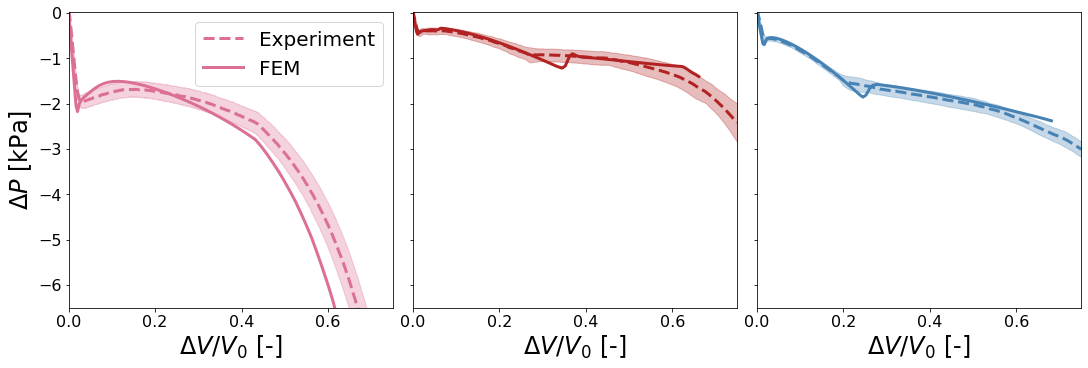

In [310]:
fig, ax = plt.subplots(1,3,figsize = figsize_three, constrained_layout = True, sharey = True)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, idx_end = -7)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[1], num_folds)
plot_sim_pv(ax[1], num_folds, idx_end = -5)

'''2 folds'''
num_folds = 2
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds)

#set parameters for plot
improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = '$\Delta P$ [kPa]', ylim_top = 0.01, ylim_bottom = -6.5, xlim_left = 0, xlim_right = 0.75, sharey = True)
ax[0].legend(loc = 'best', fontsize = fontsize_legend)

fig.savefig(f'{folder_out}/pv_all.png', dpi = 300)


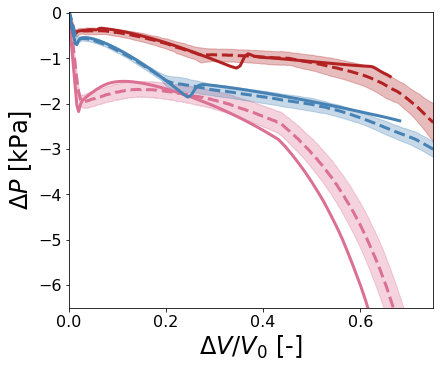

In [314]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

'''2 folds'''
num_folds = 2
plot_exp_pv(ax, num_folds)
plot_sim_pv(ax, num_folds)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax, num_folds)
plot_sim_pv(ax, num_folds, idx_end = -5)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax, num_folds)
plot_sim_pv(ax, num_folds, idx_end = -7)





#set parameters for plot
improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = '$\Delta P$ [kPa]', ylim_top = 0.01, ylim_bottom = -6.5, xlim_left = 0, xlim_right = 0.75)
# ax[0].legend(loc = 'best', fontsize = fontsize_legend)

fig.savefig(f'{folder_out}/pv_all_one_fig.png', dpi = 300)

<bound method _AxesBase.sharex of <AxesSubplot: ylabel='$\\Delta P$ [kPa]'>>

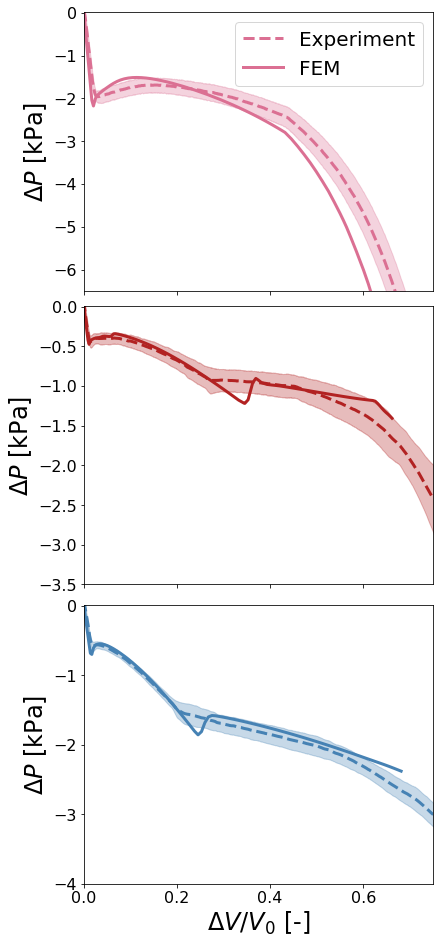

In [322]:
fig, ax = plt.subplots(3,1,figsize = figsize_three_vert, constrained_layout = True, sharex = True)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, idx_end = -7)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[1], num_folds)
plot_sim_pv(ax[1], num_folds, idx_end = -5)

'''2 folds'''
num_folds = 2
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds)

#set parameters for plot
improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = '$\Delta P$ [kPa]', ylim_top = 0.01, ylim_bottom = [-6.5, -3.5, -4], xlim_left = 0, xlim_right = 0.75, sharex = True)
ax[0].legend(loc = 'best', fontsize = fontsize_legend)
ax[0].sharex

3folds twist onset: \Delta V/V_0 = 0.286
4folds twist onset: \Delta V/V_0 = 0.204


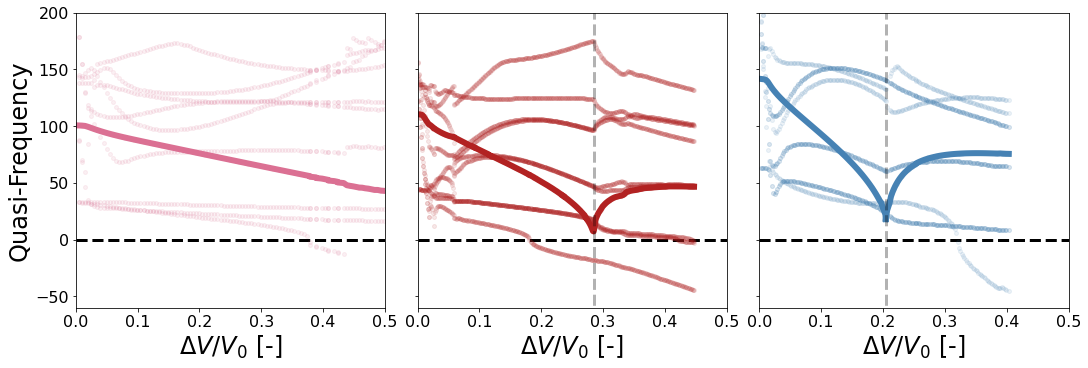

In [498]:
'''current freq plots 1x3 old style'''
fig, ax = plt.subplots(1,3,figsize = figsize_three, constrained_layout = True, sharey = True)

for axis in ax: axis.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax[0], 2)

plot_freq(ax[1], 3)

plot_freq(ax[2], 4)

idx_paste = plot_highlighted_mode(ax[0], 2, i_initial = [0,1], j_initial = [4,4])

idx_paste = plot_highlighted_mode(ax[1], 3, i_initial = [0,1], j_initial = [2,2], idx_end = -320, num_pts = 20)
idx_paste = plot_highlighted_mode(ax[1], 3, i_initial = [idx_paste, idx_paste + 1], j_initial = [5,5], select_fac = 4, idx_end = -190)
idx_paste = plot_highlighted_mode(ax[1], 3, i_initial = [idx_paste, idx_paste + 1], j_initial = [3,3], select_fac = 2, num_pts = 4, idx_end = -145)

plot_highlighted_mode(ax[1], 3, i_initial = [idx_paste, idx_paste + 1], j_initial = [1,1])
plot_vert_line_freq(ax[1], 3, idx_paste, alpha = 0.3)

#todo: make a fxn that can do piecewise highlighting
idx_paste = plot_highlighted_mode(ax[2], 4, i_initial = [0,1], j_initial = [2,2], num_pts = 4, idx_end = -109)
plot_highlighted_mode(ax[2], 4, i_initial = [idx_paste, idx_paste + 1], j_initial = [0,2])
plot_vert_line_freq(ax[2], 4, idx_paste, alpha = 0.3)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5, sharey = True)

fig.savefig(f'{folder_out}/freq_all.png', dpi = 300)

3folds twist onset: \Delta V/V_0 = 0.285
4folds twist onset: \Delta V/V_0 = 0.204


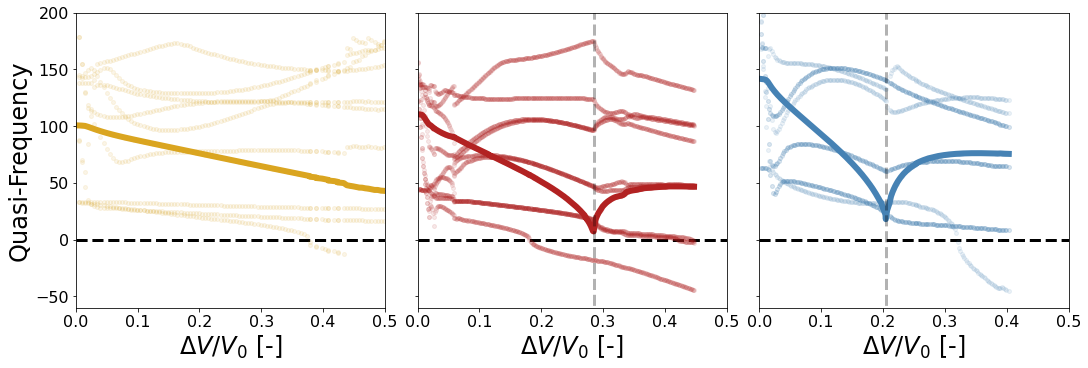

In [600]:
'current freq plots 1x3 new style'
fig, ax = plt.subplots(1,3,figsize = figsize_three, constrained_layout = True, sharey = True)

for axis in ax: axis.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax[0], 2)

plot_freq(ax[1], 3)

plot_freq(ax[2], 4)

plot_highlighted_mode_piecewise(ax[0], 2, [0,1], [[4,4]], [2], [1], [-1])

plot_highlighted_mode_piecewise(ax[1], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = True)

plot_highlighted_mode_piecewise(ax[2], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = True)

# plot_vert_line_freq(ax[2], 4, idx_paste, alpha = 0.3)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5, sharey = True)

fig.savefig(f'{folder_out}/freq_all.png', dpi = 300)

3folds twist onset: \Delta V/V_0 = 0.285
4folds twist onset: \Delta V/V_0 = 0.204


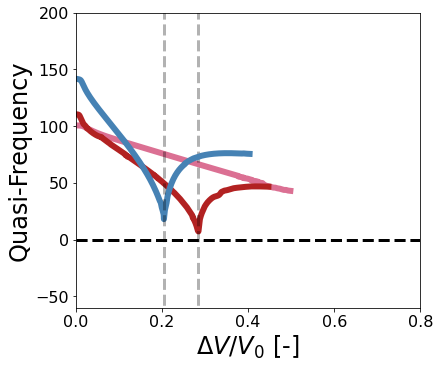

In [484]:
'''current freq plots twist mode only'''
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)
ax.hlines(0,0,1, 'k', '--', linewidth = linewidth_all)
plot_highlighted_mode_piecewise(ax, 2, [0,1], [[4,4]], [2], [1], [-1])

plot_highlighted_mode_piecewise(ax, 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = True)

plot_highlighted_mode_piecewise(ax, 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = True)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = .8)

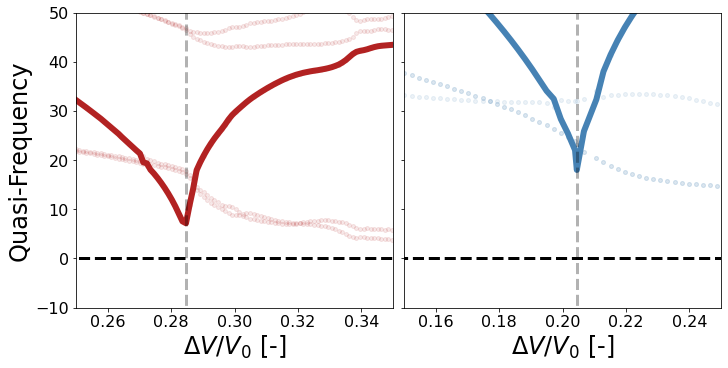

In [393]:
fig, ax = plt.subplots(1,2,figsize = figsize_two, constrained_layout = True, sharey = True)

for axis in ax: axis.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)


plot_freq(ax[0], 3)

plot_freq(ax[1], 4)


plot_highlighted_mode_piecewise(ax[0], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = True)

plot_highlighted_mode_piecewise(ax[1], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = True)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 50, ylim_bottom = -10, xlim_left = [0.25, 0.15], xlim_right = [0.35, 0.25], sharey = True)

fig.savefig(f'{folder_out}/freq_34_zoomed.png', dpi = 300, facecolor = 'white')

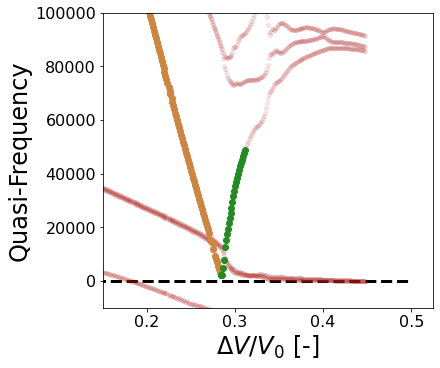

In [260]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True, sharey = True)

rescale = False
ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)
plot_freq(ax, 3, rescale = rescale)

# idx_paste = plot_highlighted_mode(ax, 3, i_initial = [0,1], j_initial = [2,2], idx_end = -320, num_pts = 20, rescale = rescale)
# idx_paste = plot_highlighted_mode(ax, 3, i_initial = [idx_paste, idx_paste + 1], j_initial = [5,5], select_fac = 4, idx_end = -230, color = 'forestgreen', rescale = rescale)
# print(idx_paste)
idx_paste = 168
# plot_highlighted_mode(ax, 3, i_initial = [idx_paste, idx_paste + 1], j_initial = [3,3], select_fac = 7, idx_end = -120)
idx_paste = plot_highlighted_mode(ax, 3, i_initial = [idx_paste, idx_paste + 1], j_initial = [3,3], select_fac = 2, num_pts = 4, idx_end = -145, color = 'peru', rescale = rescale)
plot_highlighted_mode(ax, 3, i_initial = [idx_paste, idx_paste + 1], j_initial = [1,1], idx_end = -120, color = 'forestgreen', rescale = rescale)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Eigenvalue', ylim_top = 0.1e6, ylim_bottom = -0.1e5, xlim_left = 0.15)


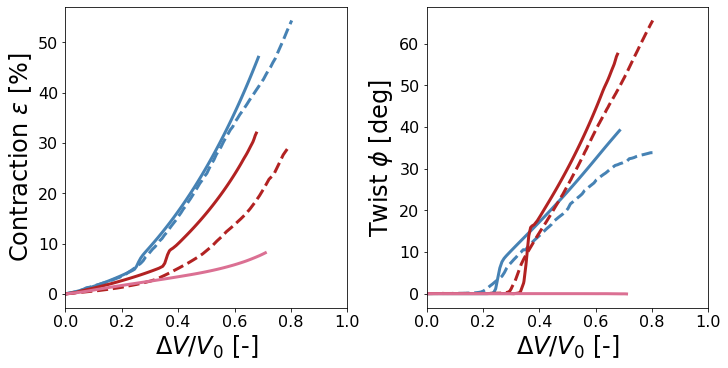

In [162]:
fig, ax = plt.subplots(1,2,figsize = figsize_two, constrained_layout = True)


'''4 folds exp'''
exp_data = np.loadtxt('exp_results/DV_4f_Exp_Updated.csv', skiprows = 1, delimiter=',')
vol_norm = exp_data[:,0]
twist_mean = np.mean(exp_data[:,1:4], axis = 1)
contraction_mean = 100*np.mean(exp_data[:,4:7], axis = 1)

ax[0].plot(vol_norm, contraction_mean, '--', linewidth = linewidth_all, label = '4 folds exp', color = color_4folds)
ax[1].plot(vol_norm, twist_mean, '--', linewidth = linewidth_all, color = color_4folds)


##########################################################
'''4 folds sim'''
end_idx = -6
idx_cur = 202
folds_num = 4
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'
props_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_props.txt'

#[self.H, self.R, self.t1, self.t2, self.theta, self.w, self.E1, self.E2, self.E_cap, self.h_element]

t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3
contraction_strain = 1 - contraction_all


ax[0].plot(vol_norm[:end_idx], contraction_strain[:end_idx]*100, linewidth = linewidth_all, label = '4 folds FEM', color = color_4folds)
ax[1].plot(vol_norm[:end_idx], twist_deg[:end_idx], linewidth = linewidth_all, color = color_4folds)
##########################################################
'''3 folds exp'''
select_fac = 8
exp_data = np.loadtxt('exp_results/DV_3f_Exp.csv', skiprows = 1, delimiter=',')
vol_norm = exp_data[:,0]
twist_mean = np.mean(exp_data[:,1:4], axis = 1)
contraction_mean = 100*np.mean(exp_data[:,4:7], axis = 1)

ax[0].plot(vol_norm[::select_fac], contraction_mean[::select_fac], '--', linewidth = linewidth_all, label = '3 folds exp', color = color_3folds)
ax[1].plot(vol_norm, twist_mean, '--', linewidth = linewidth_all, color = color_3folds)

##########################################################
'''3 folds sim'''
end_idx = -1
idx_cur = 204
folds_num = 3
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'


t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = -twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3
contraction_strain = 1 - contraction_all

ax[0].plot(vol_norm[:end_idx], contraction_strain[:end_idx]*100, linewidth = linewidth_all, label = '3 folds FEM', color = color_3folds)
ax[1].plot(vol_norm[:end_idx], twist_deg[:end_idx], linewidth = linewidth_all, color = color_3folds)


#######################################
'''2 folds sim'''
end_idx = -38
idx_cur = 200
folds_num = 2
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'


t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3
contraction_strain = 1 - contraction_all

ax[0].plot(vol_norm[:end_idx], contraction_strain[:end_idx]*100, linewidth = linewidth_all, label = '2 folds FEM', color = color_2folds)
ax[1].plot(vol_norm[:end_idx], twist_deg[:end_idx], linewidth = linewidth_all, color = color_2folds)


#######################################



ax[0].set_ylabel(r'Contraction $\varepsilon$ [%]', fontsize = fontsize_axes)
# ax[1].yaxis.tick_right()
# ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Twist $\phi$ [deg]', fontsize = fontsize_axes)

# ax[0].legend(loc = 'best', fontsize = fontsize_legend)

for axis in np.ndarray.flatten(ax):
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
    axis.set_xlim(0,1)

fig.savefig(f'{folder_out}/twist_cont_4_3.png', dpi = 300)



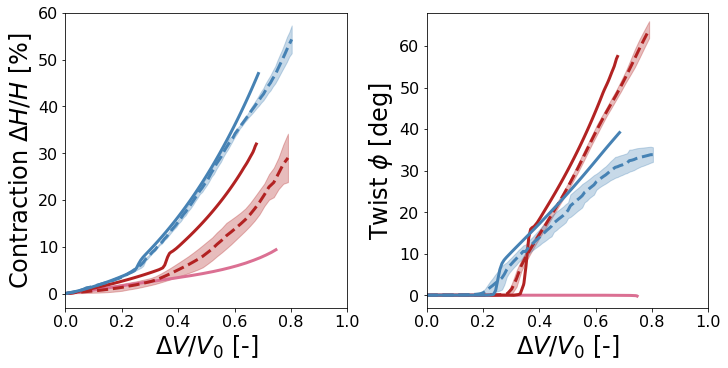

In [410]:
fig, ax = plt.subplots(1,2,figsize = figsize_two, constrained_layout = True)

plot_sim_dv(ax, 2, idx_end = 0)

plot_exp_dv(ax, 3, 8)
plot_sim_dv(ax, 3, flip = -1, idx_end = -1)

plot_exp_dv(ax, 4)
plot_sim_dv(ax, 4, idx_end = -6)

# ax[1].vlines(0.285, -10,100, 'k', '--')

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = [r'Contraction $\Delta H/H$ [%]', 'Twist $\phi$ [deg]'], xlim_left = 0, xlim_right = 1, ylim_bottom = -3, ylim_top = [60, 68])
fig.savefig(f'{folder_out}/twist_cont_4_3.png', dpi = 300)

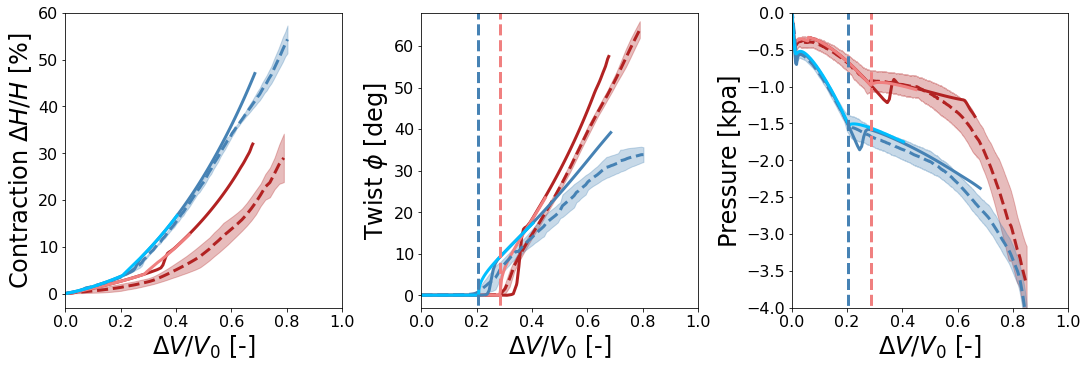

In [485]:
fig, ax = plt.subplots(1,3,figsize = figsize_three, constrained_layout = True)

# plot_sim_dv(ax, 2, idx_end = 0)

plot_exp_dv(ax, 3, 8)
plot_sim_dv(ax, 3, flip = -1, idx_end = -1)

plot_sim_dv(ax, 3, static = True, color = 'lightcoral')

plot_exp_dv(ax, 4)
plot_sim_dv(ax, 4, idx_end = -6)

plot_sim_dv(ax, 4, static = True, color = 'deepskyblue', flip = -1)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, idx_end = -5)
plot_sim_pv(ax[2], num_folds, static = True, color = 'lightcoral')

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, idx_end = -7)

plot_sim_pv(ax[2], num_folds, static = True, color = 'deepskyblue')

ax[1].vlines(0.285, -10,100, 'lightcoral', '--', linewidth = linewidth_all)
ax[1].vlines(0.204, -10,100, 'steelblue', '--', linewidth = linewidth_all)

ax[2].vlines(0.285, -10,100, 'lightcoral', '--', linewidth = linewidth_all)
ax[2].vlines(0.204, -10,100, 'steelblue', '--', linewidth = linewidth_all)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = [r'Contraction $\Delta H/H$ [%]', 'Twist $\phi$ [deg]', 'Pressure [kpa]'], xlim_left = 0, xlim_right = 1, ylim_bottom = [-3, -3, -4], ylim_top = [60, 68, 0])
fig.savefig(f'data_processed/twist_cont_static_dyn_exp.png', dpi = 300, facecolor = 'white')

3folds freq min at \Delta V/V_0 = 0.285
4folds freq min at \Delta V/V_0 = 0.204


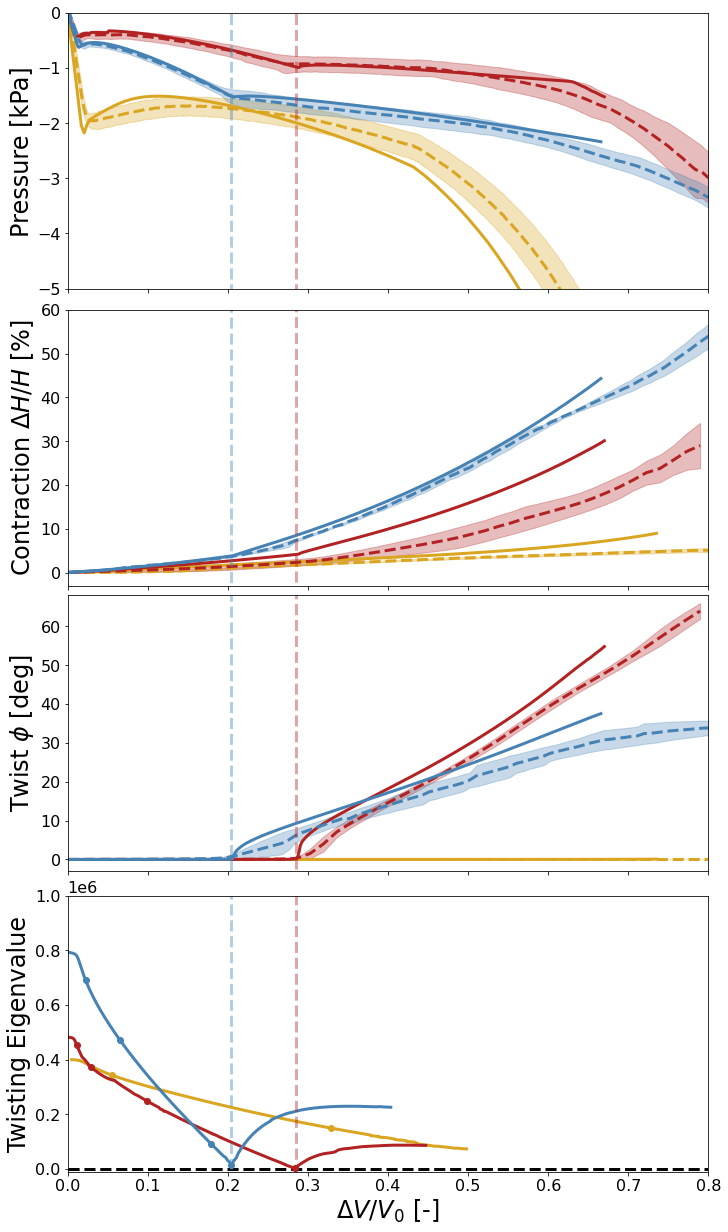

In [50]:
fig, ax = plt.subplots(4,1,figsize = figsize_four_vert, constrained_layout = True, sharex = True)

###################################
idx_end_3 = -10
idx_end_4 = -7
idx_end_2 = -25

'''2 folds'''
num_folds = 2
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, idx_end = idx_end_2)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, idx_end = idx_end_3)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, idx_end = idx_end_4)
###################################

plot_exp_dv(ax, 2, 1, offset_plots = 1)
plot_sim_dv(ax, 2, flip = -1, idx_end = idx_end_2, offset_plots = 1)

plot_exp_dv(ax, 3, 8, offset_plots = 1)
plot_sim_dv(ax, 3, flip = -1, idx_end = idx_end_3, offset_plots = 1)


plot_exp_dv(ax, 4, offset_plots = 1)
plot_sim_dv(ax, 4, flip = -1, idx_end = idx_end_4, offset_plots = 1)


##################################
ax[3].hlines(0,0,1, 'k', '--', linewidth = linewidth_all)
plot_highlighted_mode_piecewise(ax[3], 2, [0,1], [[4,4]], [2], [1], [-1], rescale = False, extra_thickness = 0, pts_plot = [10, 65])

min_3loc = plot_highlighted_mode_piecewise(ax[3], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False, rescale = False, extra_thickness = 0, color_vert_line = color_3folds, pts_plot = [9, 25, 87, 253])

min_4loc = plot_highlighted_mode_piecewise(ax[3], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False, rescale = False, extra_thickness = 0, color_vert_line = color_4folds, pts_plot = [9, 28, 79, 91])


for axis in ax:
    plot_vert_line(axis, min_3loc, alpha = 0.4, color = color_3folds)
    plot_vert_line(axis, min_4loc, alpha = 0.4, color = color_4folds)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = ['Pressure [kPa]', r'Contraction $\Delta H/H$ [%]', 'Twist $\phi$ [deg]', 'Twisting Eigenvalue'], xlim_left = 0, xlim_right = 0.8, ylim_bottom = [-5, -3, -3, -1e4], ylim_top = [0, 60, 68, 1e6], sharex = True)

ax[3].yaxis.offsetText.set_fontsize(fontsize_ticks)

print(f'3folds freq min at \Delta V/V_0 = {min_3loc:.3f}')
print(f'4folds freq min at \Delta V/V_0 = {min_4loc:.3f}')

fig.savefig(f'{folder_out}/fig2_plots.png', dpi = 300)
fig.savefig(f'{folder_out}/fig2_plots.pdf')

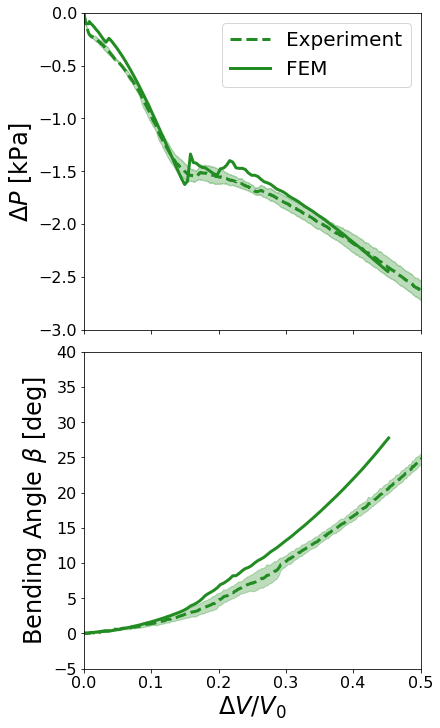

In [69]:
fig, ax = plt.subplots(2, 1, figsize = figsize_two_vert, sharex = True, constrained_layout = True)

plot_exp_bend(ax)
plot_sim_bend(ax)

ax[0].legend(loc = 'best', fontsize = fontsize_legend)
improve_plot_multi(ax, xlabel = '$\Delta V/V_0$', ylabel = ['$\Delta P$ [kPa]', r'Bending Angle $\beta$ [deg]'], sharex = True, xlim_left = 0, xlim_right = 0.5, ylim_top = [0, 40], ylim_bottom = [-3, -5])

fig.savefig(f'{folder_out}/bender_pv_ba.png', dpi = 300)
fig.savefig(f'{folder_out}/bender_pv_ba.pdf')

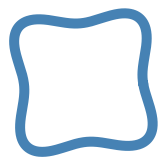

In [60]:
fig, ax = plt.subplots(figsize = (2.2, 2.2), constrained_layout = True)

num_folds = 4
#idea: add the first point and mean(1st pt, 2nd pt)

plot_lin_mode(ax, num_folds, add_border = True, extra_thickness = 7)
fig.savefig(f'{folder_out}/{num_folds}folds_lin_mode.png', dpi = 300)
fig.savefig(f'{folder_out}/{num_folds}folds_lin_mode.pdf')


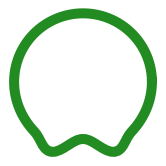

In [63]:
fig, ax = plt.subplots(figsize = (2.2, 2.2), constrained_layout = True)

num_folds = 'bend'
#idea: add the first point and mean(1st pt, 2nd pt)

plot_lin_mode(ax, num_folds, add_border = True, extra_thickness = 7)
fig.savefig(f'{folder_out}/{num_folds}folds_lin_mode.png', dpi = 300)
fig.savefig(f'{folder_out}/{num_folds}folds_lin_mode.pdf')
